## 工具包和数据导入

### 工具包导入

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import gc
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

### 数据导入

In [2]:
train = pd.read_hdf('../input/train.h5')
train.head()

,android_id,apptype,carrier,dev_height,dev_ppi,dev_width,label,lan,media_id,ntt,osv,package,sid,timestamp,version,fea_hash,location,fea1_hash,cus_type
0,316361,1199,1.0,NaN,NaN,NaN,1,NaN,104,6.0,9.0,18,1438873,2019-06-07 15:32:01,8,2.135019e+09,0,2329670524,601
1,135939,893,NaN,NaN,NaN,NaN,1,NaN,19,6.0,8.0,0,1185582,2019-06-08 19:40:40,4,2.782306e+09,1,2864801071,1000
2,399254,821,NaN,760.0,NaN,360.0,1,NaN,559,NaN,8.0,0,1555716,2019-06-06 23:59:13,0,1.392806e+09,2,628911675,696
3,68983,1004,1.0,2214.0,NaN,1080.0,0,NaN,129,2.0,8.0,0,1093419,2019-06-09 09:00:12,0,3.562553e+09,3,1283809327,753
4,288999,1076,1.0,2280.0,NaN,1080.0,1,1.0,64,2.0,8.0,0,1400089,2019-06-07 08:28:13,5,2.364522e+09,4,1510695983,582


In [3]:
test1 = pd.read_hdf('../input/test1.h5')
test1.head()

,android_id,apptype,carrier,dev_height,dev_ppi,dev_width,lan,media_id,ntt,osv,package,sid,timestamp,version,fea_hash,location,fea1_hash,cus_type
0,317625,1181,1.0,2196.0,2.0,1080.0,1.0,639,2.0,8.0,188,1440682,2019-06-07 09:42:30,7,1.672224e+09,57,3872258917,658
1,435108,944,2.0,2280.0,3.0,1080.0,1.0,704,6.0,8.0,221,1606824,2019-06-05 20:53:56,3,3.767902e+09,23,129322164,943
2,0,1106,1.0,NaN,NaN,NaN,NaN,39,2.0,5.0,1562,1774642,2019-06-04 10:07:42,0,4.546387e+08,30,4226678391,411
3,451504,761,1.0,1344.0,NaN,720.0,NaN,54,2.0,7.0,9,1742535,2019-06-05 01:03:22,0,1.507623e+09,65,3355419572,848
4,0,1001,1.0,665.0,NaN,320.0,1.0,29,5.0,8.0,4,1689686,2019-06-05 08:15:54,0,4.116351e+09,148,2644467751,411


## EDA

### 全局探索


字段 | 类型 | 说明 | 处理方式
---|---|--- | ---
sid | string | 样本id | 不处理
package | string | 媒体信息，包名 | 1950个取值，暂不处理（不好处理）
version | string | 媒体信息，app版本 | 13个取值，提取到版本号
android_id | string | 媒体信息，对外广告位ID | 362258个取值，均值编码
media_id | string | 媒体信息，对外媒体ID，284个取值 | 284个取值，均值编码
apptype | int | 媒体信息，app所属分类 | 89个取值，均值编码
timestamp | bigint | 请求到达服务时间，单位ms | 时间点
location | int | 用户地理位置编码（精确到城市） | 332个取值，均值编码
fea_hash | int | 用户特征编码 | 402980个取值，不处理
fea1_hash | int | 用户特征编码 | 4959个取值，不处理
cus_type | int | 用户特征编码 | 58个取值，不处理
ntt | int | 网络类型 0-未知, 1-有线网, 2-WIFI, 3-蜂窝网络未知, 4-2G, 5-3G, 6–4G | 独热编码
carrier | string | 设备使用的运营商 0-未知, 46000-移动, 46001-联通, 46003-电信 | 独热编码
os | string | 操作系统，默认为android | 取值全为安卓，删除特征
osv | string | 操作系统版本 | 提取到版本号，11个取值
lan | string | 设备采用的语言，默认为中文 | 10个取值，独热编码
dev_height | int | 设备高 | 不处理
dev_width | int | 设备宽 | 不处理
dev_ppi | int | 屏幕分辨率 | 不处理

#### train数据集探索

1. train数据集由50000行19列组成

In [4]:
train.shape

(500000, 19)

2. 所有的sid都不相同

In [5]:
train['sid'].nunique()

500000

3. 样本经过采样处理

In [6]:
train['label'].mean()

0.48448

4. train数据集有x个数值型，x个object类型

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 499999
Data columns (total 19 columns):
android_id    500000 non-null int32
apptype       500000 non-null int16
carrier       435093 non-null float64
dev_height    392986 non-null float16
dev_ppi       116709 non-null float16
dev_width     392989 non-null float16
label         500000 non-null int8
lan           316720 non-null float64
media_id      500000 non-null int16
ntt           479383 non-null float16
osv           493439 non-null float64
package       500000 non-null int16
sid           500000 non-null int32
timestamp     500000 non-null object
version       500000 non-null int64
fea_hash      499910 non-null float64
location      500000 non-null int16
fea1_hash     500000 non-null int64
cus_type      500000 non-null int16
dtypes: float16(4), float64(4), int16(5), int32(2), int64(2), int8(1), object(1)
memory usage: 43.4+ MB


5. 特征类型

(1) ID特征（1个）：sid

(2) 类别特征（12个）：label, android_id, apptype, carrier, lan, media_id, ntt, osv, version, location, cus_type, package

(3) 数值特征（5个）：dev_height, dev_ppi, dev_width, fea_hash, fea1_hash, 

(4) 时间特征（1个）：timestamp

In [8]:
train.nunique()

android_id    362258
apptype           89
carrier            3
dev_height       746
dev_ppi           91
dev_width        324
label              2
lan               10
media_id         284
ntt                7
osv               11
package         1950
sid           500000
timestamp       4615
version           13
fea_hash      402890
location         332
fea1_hash       4959
cus_type          58
dtype: int64

**结论**
1. train数据集由50000行19列组成

2. train中所有的id是不一样的

3. label经过采样，所以点击率是平衡的（无需进行特殊的处理）

4. 训练集和测试集中的id存在4个id是有交互的

5. 特征类型

(1) ID特征（1个）：sid

(2) 类别特征（12个）：label, android_id, apptype, carrier, lan, media_id, ntt, osv, version, location, cus_type, package

(3) 数值特征（5个）：dev_height, dev_ppi, dev_width, fea_hash, fea1_hash, 

(4) 时间特征（1个）：timestamp

#### 测试集探索

1. 测试集中有18个特征，少了label特征

In [9]:
test1.nunique()

android_id    110483
apptype           78
carrier            3
dev_height       560
dev_ppi           57
dev_width        221
lan                7
media_id         248
ntt                6
osv                9
package         1293
sid           150000
timestamp       4615
version           13
fea_hash      135061
location         332
fea1_hash       2159
cus_type          58
dtype: int64

2. 测试集中的类别特征有很多在训练集中可能没有出现过，那么这些类别特征在预测时将会较难预测,所以我们得重点观察此类数据.

    - 我们发现例如media_id，package特征中,都出现了很多测试集中出现但是在训练集中并未出现的特征.所以后续处理的时候可以考虑特殊的编码。

In [10]:
cate_cols = ['android_id', 'apptype', 'carrier', 'lan', 'media_id', 'ntt', 'osv',
             'version', 'location', 'cus_type', 'package']

print('There are about {} categorical features.'.format(len(cate_cols)))

for col in cate_cols:
    print(col, len(set(test1[col].unique()) - set(train[col].unique())))

There are about 11 categorical features.
android_id 105700
apptype 0
carrier 1
lan 1
media_id 8
ntt 1
osv 1
version 0
location 0
cus_type 0
package 152


In [11]:
test1['carrier'].unique()

array([ 1.,  2., nan,  3.])

In [12]:
train['carrier'].unique()

array([ 1., nan,  2.,  3.])

3. android_id有很多交互

In [13]:
len(set(train['android_id']) - set(test1['android_id']))

357475

4. 时间特征

In [14]:
train['timestamp'].sort_values(ascending=True)[-5:]

444074    2019-06-10 00:00:14
272932    2019-06-10 00:00:14
182118    2019-06-10 00:00:14
39805     2019-06-10 00:00:14
26651     2019-06-10 00:00:14
Name: timestamp, dtype: object

In [15]:
test1['timestamp'].sort_values(ascending=True)[:5]

145991    2019-06-03 00:00:48
7518      2019-06-03 00:00:48
38849     2019-06-03 00:00:48
136392    2019-06-03 00:00:48
103170    2019-06-03 00:00:48
Name: timestamp, dtype: object

**结论**
1. 测试集有18个特征
2. 测试集中的类别特征有很多在训练集中没有出现过
3. 训练集和测试集中的android_id有很多交互

In [16]:
data = pd.concat([train, test1], axis=0, ignore_index=True)

for col in cate_cols: 
    print(col)
    data[col + '_cnt_code'] = data.groupby(col)['label'].transform('count') 

data.head()

android_id
apptype
carrier
lan
media_id
ntt
osv
version
location
cus_type
package


,android_id,apptype,carrier,cus_type,dev_height,dev_ppi,dev_width,fea1_hash,fea_hash,label,lan,location,media_id,ntt,osv,package,sid,timestamp,version,android_id_cnt_code,apptype_cnt_code,carrier_cnt_code,lan_cnt_code,media_id_cnt_code,ntt_cnt_code,osv_cnt_code,version_cnt_code,location_cnt_code,cus_type_cnt_code,package_cnt_code
0,316361,1199,1.0,601,NaN,NaN,NaN,2329670524,2.135019e+09,1.0,NaN,0,104,6.0,9.0,18,1438873,2019-06-07 15:32:01,8,1,23212,359409.0,NaN,22317,116548.0,104712.0,38348,11647,6456,22367
1,135939,893,NaN,1000,NaN,NaN,NaN,2864801071,2.782306e+09,1.0,NaN,1,19,6.0,8.0,0,1185582,2019-06-08 19:40:40,4,1,27155,NaN,NaN,8829,116548.0,199441.0,24262,5527,6480,131906
2,399254,821,NaN,696,760.0,NaN,360.0,628911675,1.392806e+09,1.0,NaN,2,559,NaN,8.0,0,1555716,2019-06-06 23:59:13,0,1,1504,NaN,NaN,284,NaN,199441.0,292156,1536,6459,131906
3,68983,1004,1.0,753,2214.0,NaN,1080.0,1283809327,3.562553e+09,0.0,NaN,3,129,2.0,8.0,0,1093419,2019-06-09 09:00:12,0,1,16721,359409.0,NaN,2081,318597.0,199441.0,292156,1458,6413,131906
4,288999,1076,1.0,582,2280.0,NaN,1080.0,1510695983,2.364522e+09,1.0,1.0,4,64,2.0,8.0,0,1400089,2019-06-07 08:28:13,5,1,40183,359409.0,316452.0,40175,318597.0,199441.0,56692,5598,6484,131906


In [17]:
for col in cate_cols: 
    print(col + '_cnt_code') 

android_id_cnt_code
apptype_cnt_code
carrier_cnt_code
lan_cnt_code
media_id_cnt_code
ntt_cnt_code
osv_cnt_code
version_cnt_code
location_cnt_code
cus_type_cnt_code
package_cnt_code


In [18]:
data['timestamp'].tail()

649995    2019-06-08 09:22:26
649996    2019-06-07 07:16:08
649997    2019-06-09 08:49:17
649998    2019-06-05 06:37:36
649999    2019-06-08 07:22:17
Name: timestamp, dtype: object

In [19]:
data['day'] = data['timestamp'].apply(lambda x: str(x)[8:10]).astype(int)
data['hour'] = data['timestamp'].apply(lambda x: str(x)[11:13]).astype(int)

In [20]:
train_data = data.iloc[:train.shape[0], :]
test1_data = data.iloc[train.shape[0]:, :]

train_data_y = train_data['label']
train_data_X = train_data.drop('label', axis=1)

test1_data_y = test1_data['label']
test1_data_X = test1_data.drop('label', axis=1)

In [21]:
train_data_X_train, train_data_X_val, train_data_y_train, train_data_y_val = train_test_split(train_data_X, train_data_y, random_state=2020)

In [22]:
train_cols = [i for i in train_data_X_train.columns if i not in ['sid'] and train_data_X_train[i].dtypes != 'O']

In [23]:
lgb_train = lgb.Dataset(train_data_X_train[train_cols], train_data_y_train)
lgb_eval = lgb.Dataset(train_data_X_val[train_cols], train_data_y_val,
                       reference=lgb_train)

In [24]:
params = {'task': 'train',
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric': {'binary_logloss'},
          'num_leaves': 255,
          'learning_rate': 0.05,
          'feature_fraction': 0.95,
          'bagging_fraction': 0.85,
          'bagging_freq': 5, 
          'min_data_in_leaf':15,
          'verbose': 0}

print('Start training...')

gbm_val_1 = lgb.train(params,
                      lgb_train,
                      num_boost_round=2000,
                      valid_sets=[lgb_train, lgb_eval],
                      early_stopping_rounds=50,
                      verbose_eval=10)

Start training...
Training until validation scores don't improve for 50 rounds
[10]	training's binary_logloss: 0.483262	valid_1's binary_logloss: 0.484438
[20]	training's binary_logloss: 0.390275	valid_1's binary_logloss: 0.392415
[30]	training's binary_logloss: 0.343543	valid_1's binary_logloss: 0.346557
[40]	training's binary_logloss: 0.319528	valid_1's binary_logloss: 0.323457
[50]	training's binary_logloss: 0.306376	valid_1's binary_logloss: 0.311506
[60]	training's binary_logloss: 0.298196	valid_1's binary_logloss: 0.304675
[70]	training's binary_logloss: 0.29308	valid_1's binary_logloss: 0.30111
[80]	training's binary_logloss: 0.289331	valid_1's binary_logloss: 0.299303
[90]	training's binary_logloss: 0.285909	valid_1's binary_logloss: 0.297925
[100]	training's binary_logloss: 0.282999	valid_1's binary_logloss: 0.296981
[110]	training's binary_logloss: 0.280392	valid_1's binary_logloss: 0.296519
[120]	training's binary_logloss: 0.278084	valid_1's binary_logloss: 0.2963
[130]	trai

In [25]:
lgb_train = lgb.Dataset(train_data_X[train_cols], train_data_y)   

print('Start training...')

gbm_1  = lgb.train(params,
                   lgb_train,
                   num_boost_round=gbm_val_1.best_iteration + 20)

test1['label'] = np.where(gbm_1.predict(test1_data_X[train_cols]) > 0.5, 1, 0)

test1[['sid', 'label']].to_csv('../results/sub_20200607_11.csv', index=False)

Start training...


## 单个特征列nunique分布

1. ID变量

id_feat = ['sid', 'android_id', 'media_id']

2. 类别变量

categorical_feat = ['carrier', 'apptype', 'lan', 'ntt', 'osv', 'package', 'version', 'location', 'cus_type']

3. 数值变量

numeric_feat = ['dev_height', 'dev_width', 'dev_ppi', 'fea_hash', 'fea1_hash']

4. 时间变量

time_feat = ['timestamp']

哑变量：

categorical_feat = ['carrier', 'apptype', 'lan', 'ntt', 'osv', 'version', 'cus_type']

### 设备使用的运营商 0-未知, 46000-移动, 46001-联通, 46003-电信

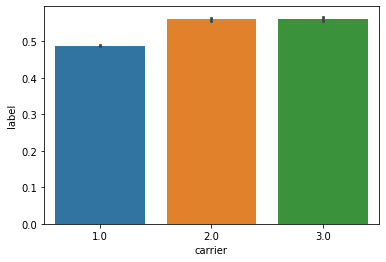

In [11]:
sns.barplot(x='carrier', y='label',
            data=train)

### 媒体信息，app所属分类

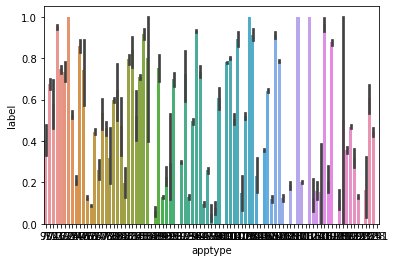

In [12]:
sns.barplot(x='apptype', y='label',
            data=train)

### 设备采用的语言，默认为中文

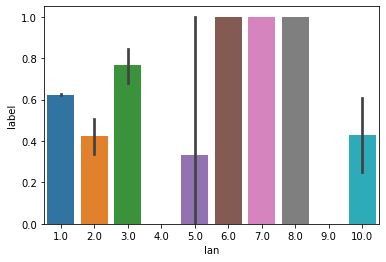

In [13]:
sns.barplot(x='lan', y='label',
            data=train)

### 网络类型 0-未知, 1-有线网, 2-WIFI, 3-蜂窝网络未知, 4-2G, 5-3G, 6–4G

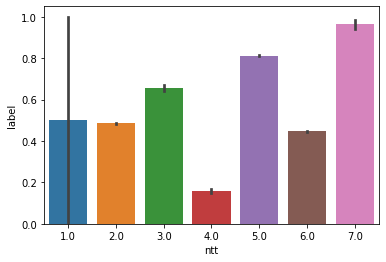

In [14]:
sns.barplot(x='ntt', y='label',
            data=train)

### 操作系统版本

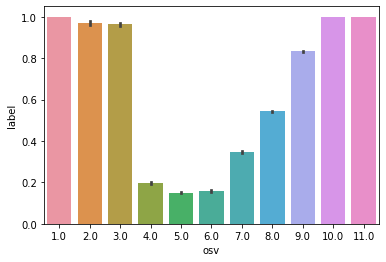

In [15]:
sns.barplot(x='osv', y='label',
            data=train)

### 媒体信息，包名（已加密）

In [16]:
# sns.barplot(x='package', y='label',
#             data=train)

### 媒体信息，app版本

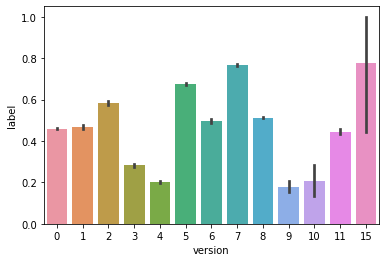

In [17]:
sns.barplot(x='version', y='label',
            data=train)

### 用户特征编码（具体物理含义略去）

In [18]:
# sns.barplot(x='fea_hash', y='label',
#             data=train)

### 用户特征编码（具体物理含义略去）

In [19]:
# sns.barplot(x='fea1_hash', y='label',
#             data=train)

### 用户地理位置编码（精确到城市）

In [20]:
# sns.barplot(x='location', y='label',
#             data=train)

### 用户特征编码（具体物理含义略去）

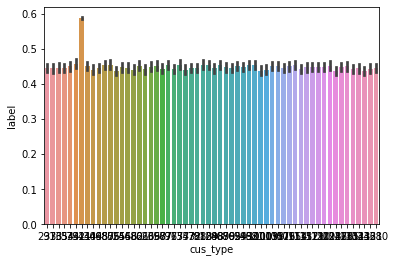

In [21]:
sns.barplot(x='cus_type', y='label',
            data=train)